# Classificazione con algoritmi della libreria sklearn

### 0) Importo le librerie necessarie

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### 1) Carico e preparo i dati

In [3]:
# Carico il dataset
path = '../color_extr/data.csv'
data = pd.read_csv(path, usecols = [i for i in range(5)])

# Creo train e test set
X_train, X_test, Y_train, Y_test = train_test_split(data[['presenza_foglie','assenza_foglie','presenza_bachi_sfondo','assenza_bachi_sfondo']], data[['classificazione']], test_size=0.23)

# Normalizzo i dati
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

### 2) Trovo il modello più adatto - Model Selection

In [5]:
import warnings
warnings.filterwarnings('ignore')

# get a list of models to evaluate
models = [LogisticRegression(), KNeighborsClassifier(), svm.SVC()] 
 
#Implementing cross validation
 
k = 5
kf = KFold(n_splits=k, random_state=None)

for model in models:
	result = cross_val_score(model , X_train, Y_train, cv = kf)
 
	print("- ", str(type(model).__name__).strip(), "avg accuracy: ", str(result.mean()))

-  LogisticRegression avg accuracy:  0.9875
-  KNeighborsClassifier avg accuracy:  0.9913461538461539
-  SVC avg accuracy:  0.9884615384615385


### 3) Hyperparameter Tuning - GridSearchCV

In [8]:
grid_params = { 'n_neighbors' : [5,7,9,11,13,15],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

print(type(models[1]).__name__)

gs = GridSearchCV(models[1], grid_params, verbose = 1, cv=3, n_jobs = -1)

g_res = gs.fit(X_train, Y_train)
g_res.best_params_

KNeighborsClassifier
Fitting 3 folds for each of 36 candidates, totalling 108 fits


{'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'distance'}

### 4) Model Assestments di KNN in base ai risultati ottenuti

In [22]:
model_knn = KNeighborsClassifier(n_neighbors = 13, weights = 'distance', metric = 'minkowski')


- Learning curves

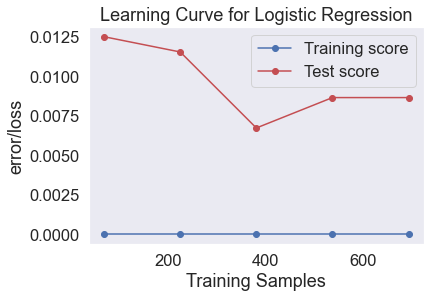

In [30]:
import warnings
warnings.filterwarnings('ignore')

train_size, train_score, test_score = learning_curve(estimator=model_knn, X=X_train, y=Y_train, cv=3, scoring = None )

train_loss_m = 1 - np.mean(train_score, axis=1)
test_loss_m = 1- np.mean(test_score, axis=1)

plt.plot(train_size, train_loss_m, 'o-', color="b")
plt.plot(train_size, test_loss_m, 'o-', color="r")
plt.legend(('Training score', 'Test score'), loc='best')
plt.xlabel("Training Samples")
plt.ylabel("error/loss")
plt.title("Learning Curve for Logistic Regression")
plt.grid()

plt.show()

- Alleno il modello ottimale e ottengo le predizioni

In [25]:
knn_fit = model_knn.fit(X_train, Y_train)
predictions_knn = model_knn.predict(X_test)
predictions_lr_scores = model_knn.predict_proba(X_test)[:,1]

train_score = model_knn.score(X_train, Y_train)
test_score = model_knn.score(X_test, Y_test)
print("### KNN:\n\tAccuracy of training: "+str(train_score)+"\n\tAccuracy of test: "+str(test_score))
print("### KNN:\n\tError rate of training: "+str(1 - train_score)+"\n\tError rate of test: "+str(1 - test_score))

### KNN:
	Accuracy of training: 1.0
	Accuracy of test: 0.9678456591639871
### KNN:
	Error rate of training: 0.0
	Error rate of test: 0.032154340836012874


- Metrica d'errore

In [24]:
metric_error = len(data[data.classificazione == 0]) / len(data)
metric_accurancy = 1 - metric_error

(metric_error,metric_accurancy)

(0.44041450777202074, 0.5595854922279793)

- Confusion Matrix

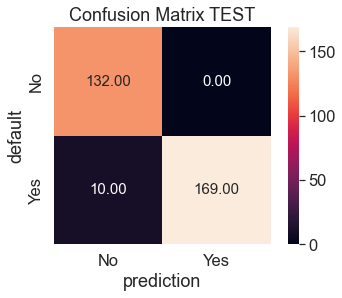

In [26]:
cm = confusion_matrix(Y_test, predictions_knn)
plt.figure()
sns.set(font_scale=1.5)
hm = sns.heatmap( cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=['No', 'Yes'], xticklabels=['No', 'Yes'])
plt.title('Confusion Matrix TEST')
plt.ylabel('default')
plt.xlabel('prediction')
plt.show()

- Precision e Recall

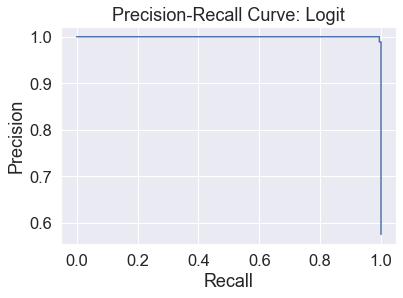

Precision:  0.988950276243094
Recall:  1.0
f1-score:  0.9712643678160919


In [27]:
precision, recall, thresholds = precision_recall_curve(Y_test, predictions_lr_scores)
plt.figure()
plt.plot(recall, precision)
plt.title("Precision-Recall Curve: Logit")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print("Precision: ", precision[1])
print("Recall: ", recall[1])
print("f1-score: ", f1_score(Y_test, predictions_knn))

- ROC e AUC curve

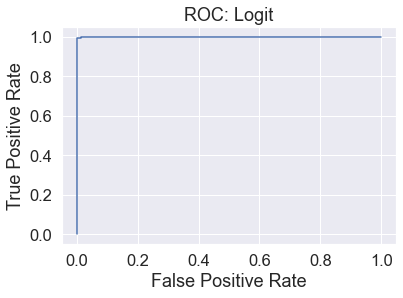

AUC:  0.9720670391061452


In [28]:
fpr, tpr, thresholds = roc_curve(Y_test, predictions_lr_scores)
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC: Logit")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print ("AUC: ", roc_auc_score(Y_test, predictions_knn))

### 5)Conclusioni